<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# 물체 검출

## 배포판 사용하기

이미지의 256x256 부분을 분류하도록 학습된 이미지 분류기와 슬라이딩 윈도우를 결합하면 전체 이미지의 각 부분을 256x256 씩 살피면서 개인지 고양이인지를 분류할 수 있습니다. 이 방법이 완벽한 솔루션은 아니지만,

1) 심층 학습과 전통적 프로그래밍을 결합하여 이전에는 불가능했던 애플리케이션을 만드는 훌륭한 사례입니다.
2) 신경망 아키텍쳐에 대해 학습할 수 있는 시작점이 됩니다.

본 강좌의 첫 번째 부분에서 여러분은 신경망을 성공적으로 학습하고 적용하는 방법을 배웠습니다. 전통적인 프로그래밍이 이미지를 분류하는 적절한 방법이 될 수 없음과, 심층 학습이 이를 가능케 해 줄 뿐만 아니라 직관적이기까지 하다는 것을 배웠습니다.

상점에 있는 상품을 고르듯이 이미 완성된 신경망과 (dogs vs. cats 같은) 오픈소스 데이터 세트를 골라서 모델을 만들면 새로운 동물이 여러분의 초기 데이터 세트와 유사한지 아닌지 올바르게 분류할 수 있었습니다.

**이번** 작업에서 여러분은 심층 학습을 이용하여 *이미지 분류 이상의* 문제를 푸는 방법을 배웁니다. 이를 위해 아래와 같은 과정을 거칩니다.

- 심층 학습과 전통적인 컴퓨터 비젼을 결합한다.
- 신경망의 내부(실제 수식)를 변경한다.
- 작업에 적합한 신경망을 선택한다.

두 번째 심층 학습 과제는 다음과 같습니다.

** 이미지 안에서 물체를 *검출(detect)*하고 *위치를 지정(localize)*할 수 있나요?**

지난 섹션에서 했던 방식대로 모델을 만들기 시작해 봅시다. 모델 아키텍쳐, 학습된 가중치, 평균 이미지와 같은 선처리 정보를 사용하기 위해 모델과 데이터 세트 작업 디렉토리를 불러 들입니다.

In [1]:
import time
import numpy as np #Data is often stored as "Numpy Arrays"
import matplotlib.pyplot as plt #matplotlib.pyplot allows us to visualize results
import caffe #caffe is our deep learning framework, we'll learn a lot more about this later in this task.
%matplotlib inline

MODEL_JOB_DIR = '/dli/data/digits/20180301-185638-e918'  ## Remember to set this to be the job directory for your model
DATASET_JOB_DIR = '/dli/data/digits/20180222-165843-ada0'  ## Remember to set this to be the job directory for your dataset

MODEL_FILE = MODEL_JOB_DIR + '/deploy.prototxt'                 # This file contains the description of the network architecture
PRETRAINED = MODEL_JOB_DIR + '/snapshot_iter_735.caffemodel'    # This file contains the *weights* that were "learned" during training
MEAN_IMAGE = DATASET_JOB_DIR + '/mean.jpg'                      # This file contains the mean image of the entire dataset. Used to preprocess the data.

# Tell Caffe to use the GPU so it can take advantage of parallel processing. 
# If you have a few hours, you're welcome to change gpu to cpu and see how much time it takes to deploy models in series. 
caffe.set_mode_gpu()
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# load the mean image from the file
mean_image = caffe.io.load_image(MEAN_IMAGE)
print("Ready to predict.")

Ready to predict.


다음으로 이미지를 대문 보안 카메라에서 직접 읽어 들입니다. 이 이미지는 256x256보다 크다는 것에 유념하세요. 우리는 이 이미지 안 어디에 개가 있는지 알고자 합니다.

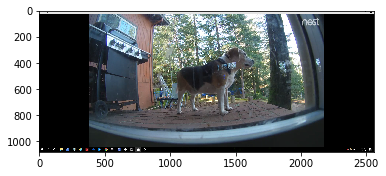

In [2]:
# Choose a random image to test against
#RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = '/dli/data/LouieReady.png'
input_image= caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

## **학습된** 함수 사용하기: 순전파 (forward propagation)

우리가 관심있어 하는 아래 함수를 봅시다.

<code>
prediction = net.predict([grid_square])
</code>.

여타의 [함수](https://www.khanacademy.org/computing/computer-programming/programming#functions)와 마찬가지로, <code>net.predict</code>는 입력(여기에서는 <code>grid_square</code>)을 전달하면 출력(여기에서는 <code>prediction</code>)을 내어 줍니다. 이 함수는 이미지를 확률값의 벡터로 바꾸어 주기 위한 일련의 행렬 계산을 반복합니다.

아래 셀을 실행해서 우리의 랜덤 이미지 중 좌상단 256x256 <code>grid_square</code>로부터의 예측값을 살펴 보세요.

In [3]:
X = 0
Y = 0

grid_square = input_image[X*256:(X+1)*256,Y*256:(Y+1)*256]
# subtract the mean image (because we subtracted it while we trained the network - more on this in next lab)
grid_square -= mean_image
# make prediction
prediction = net.predict([grid_square])
print prediction

[[ 0.92268908  0.07731096]]


이것은 우리가 사용 중인 신경망의 가장 마지막 계층의 출력입니다. 여기서 사용된 계층은 "소프트맥스(softmax)"라는 것인데, 각 셀의 값이 클수록 이미지가 특정 클래스에 속하는 정도가 높다는 것을 나타냅니다. 위의 예에서 (당연히, 해당 신경망이 학습된 것이고) 벡터의 두 번째 값이 첫 번째보다 크다면 이미지의 해당 부분은 개를 포함할 가능성이 크다는 뜻입니다. 우리의 경우 첫 번째 셀의 값이 *훨씬* 크기 때문에 이미지의 좌상단 256x256 부분에는 개가 없다는 것이 명백합니다.

선택 학습: [소프트맥스를 계산하는 방법을 살펴 보세요](https://en.wikipedia.org/wiki/Softmax_function).

다음으로 이 함수를 가지고 코드를 작성하여 이미지 전체에 대해 반복하고 각 grid_square를 분류하여 색지도(heatmap)를 만들어 봅시다. 여기에서 중요한 점은 여러분이 이 함수를 이용해서 원하는 무엇이든 만들 수 있다는 점입니다. 여러분의 상상력이 유일한 한계일 것입니다.

여러분의 (특히 파이썬) 프로그래밍 경험에 따라 다음 명령 셀에서 매우 다른 정보를 얻어낼 것입니다. 핵심적인 사항은 이 코드 블록이 이미지를 256x256 정방형으로 잘라서 각각을 개 분류기에 넣고, 개가 없는 곳에는 파란색, 개가 있는 곳에는 빨간색을 가진 새로운 이미지를 생성한다는 점입니다. 분류기에 의해 결정된 바와 같이 빨간색은 하나만 있습니다. 

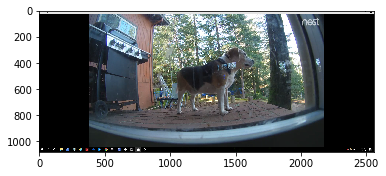

Total inference time: 2.81084489822 seconds


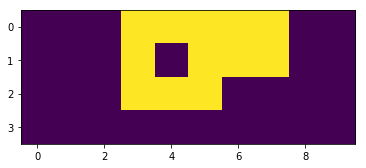

In [4]:
# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # subtract the mean image
        grid_square -= mean_image
        # make prediction
        prediction = net.predict([grid_square]) 
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections, interpolation=None)

# Display total time to perform inference
print 'Total inference time: ' + str(end-start) + ' seconds'

다시 말씀드리지만, 출력은 임의로 선택된 큰 테스트 이미지에 대하여, 겹치지 않는 256x256 격자 사각형들에 대한 예측을 나타내는 배열입니다.

개선책을 논하기에 앞서 우리가 방금 한 내용을 생각해보고 아래 질문에 답해 봅시다. 

** 물체를 검출하기 위해 우리가 어떻게 했는지 여러분 나름대로 설명해 보세요. **

메인 강좌로 돌아갔을 때 사용하기 위해 여러분의 생각을 여기에 적으세요.


본 섹션의 목적은 어떠한 심층 학습 솔루션도 결국은 입력을 출력에 매핑하는 데 불과하다는 것을 밝히는 것입니다. 이 점을 인식하면 더 복잡한 솔루션을 어떻게 만들 수 있을지에 대한 이해가 한층 높아집니다. 예를 들어 알렉사, 구글 어시시턴트, 시리와 같은 음성 비서 기능은 순수 소리 데이터를 문자로 바꾸고, 문자를 이해로 바꾸고, 여러분이 좋아하는 음악을 플레이하는 것과 같이 이해를 원하는 작업으로 바꾸는 것입니다.

<a id='question1'></a>
<a id='back1'></a>

복잡도로 보자면 컴퓨터 과학으로 만들었거나 만들 수 있는 모든 것을 포괄할 수 있습니다. 코딩 및 문제 해결 과제로서 다음을 생각해 봅시다. 솔루션을 만들면서 우리가 고려하지 못한 사항들이 무엇이며 어떻게 그것들을 고려할 수 있을까요? 

여러분의 생각을 기록하세요: 


해답을 보시려면 [여기](#answer1)를 클릭하세요.

### 도전 과제 실습 (선택사항)

<a id='question-optional-exercise'></a>
<a id='back2'></a>

아래의 옵션으로 추가적인 작업을 해보세요 

1. 격자 크기를 256x256으로 하되, 보다 세밀한 분류 지도를 만들기 위해 격자를 오버랩시키도록 코드를 수정하세요.
2. 다수의 격자를 한꺼번에 배치(batch)로 신경망에 전달하도록 코드를 수정하세요.





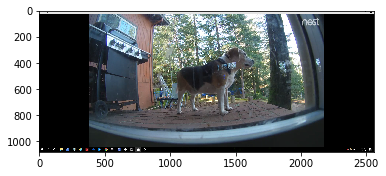

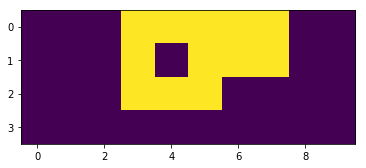

Total inference time (sliding window without overlap): 2.82832717896 seconds
Image has 4*10 blocks of 256 pixels
With overlap=0.250000 grid_size=5*13


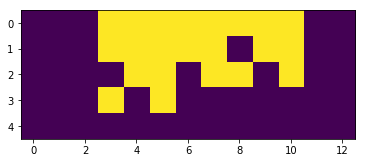

Total inference time (sliding window with 25.000000% overlap: 4.58199810982 seconds


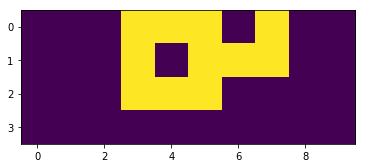

Total inference time (batched inference): 0.118152856827 seconds


In [9]:
# try Overlap 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import time

MODEL_JOB_NUM = '/dli/data/digits/20180301-185638-e918'  ## Remember to set this to be the job directory for your model
DATASET_JOB_NUM = '/dli/data/digits/20180222-165843-ada0'  ## Remember to set this to be the job directory for your dataset

MODEL_FILE = MODEL_JOB_NUM + '/deploy.prototxt'                 # Do not change
PRETRAINED = MODEL_JOB_NUM + '/snapshot_iter_735.caffemodel'    # Do not change
MEAN_IMAGE = DATASET_JOB_NUM + '/mean.jpg'                      # Do not change

# load the mean image
mean_image = caffe.io.load_image(MEAN_IMAGE)

# Choose a random image to test against
#RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = '/dli/data/LouieReady.png' 

# Tell Caffe to use the GPU
caffe.set_mode_gpu()
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Subtract the mean image
for i in range(0,rows):
    for j in range(0,cols):
        input_image[i*256:(i+1)*256,j*256:(j+1)*256] -= mean_image
        
# Initialize an empty array for the detections
detections = np.zeros((rows,cols))
        
# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (sliding window without overlap): ' + str(end-start) + ' seconds'

# define the amount of overlap between grid cells
OVERLAP = 0.25
grid_rows = int((rows-1)/(1-OVERLAP))+1
grid_cols = int((cols-1)/(1-OVERLAP))+1

print "Image has %d*%d blocks of 256 pixels" % (rows, cols)
print "With overlap=%f grid_size=%d*%d" % (OVERLAP, grid_rows, grid_cols)

# Initialize an empty array for the detections
detections = np.zeros((grid_rows,grid_cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,grid_rows):
    for j in range(0,grid_cols):
        start_col = int(j*256*(1-OVERLAP))
        start_row = int(i*256*(1-OVERLAP))
        grid_square = input_image[start_row:start_row+256, start_col:start_col+256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print ('Total inference time (sliding window with %f%% overlap: ' % (OVERLAP*100)) + str(end-start) + ' seconds'

# now with batched inference (one column at a time)
# we are not using a caffe.Classifier here so we need to do the pre-processing
# manually. The model was trained on random crops (256*256->227*227) so we
# need to do the cropping below. Similarly, we need to convert images
# from Numpy's Height*Width*Channel (HWC) format to Channel*Height*Width (CHW) 
# Lastly, we need to swap channels from RGB to BGR
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
start = time.time()
net.blobs['data'].reshape(*[grid_cols, 3, 227, 227])

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # add to batch
        grid_square = grid_square[14:241,14:241] # 227*227 center crop        
        image = np.copy(grid_square.transpose(2,0,1)) # transpose from HWC to CHW
        image = image * 255 # rescale
        image = image[(2,1,0), :, :] # swap channels
        net.blobs['data'].data[j] = image
    # make prediction
    output = net.forward()[net.outputs[-1]]
    for j in range(0,cols):
        detections[i,j] = output[j].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (batched inference): ' + str(end-start) + ' seconds'


해답을 보시려면 [여기](#answer-optional-exercise)를 클릭하세요.

지금까지 보았듯이 슬라이딩 윈도우 기법의 장점은 검출인식기를 학습시킬 때 (쉽게 구할 수 있는) 부분 학습 데이터(patch-based training data)를 사용할 수 있다는 점과, 현재 우리가 가진 기술만으로도 문제 해결을 시도할 수 있다는 점입니다.

코드를 계속 수정해 갈 때, 무작위 기법(brute force)을 이용하여 느리고 부정확하게 진행할 수도 있고 심층 학습에 대해 더 공부하고 진행할 수도 있습니다. 우리는 후자를 택하겠습니다.

## 두 번째 접근법 - 기존 신경망으로부터 다시 만들기

심층 신경망은 인간의 뇌에서 영감을 받은 것임을 기억하세요. 본 섹션에서는 동작과 성능을 변경하기 위해 신경망을 바꾸는 방법을 볼 것입니다. 핵심은, 신경망은 수학으로 만들었고, 수식을 바꾸면 뇌가 바뀐다는 점입니다. 특정 종류의 신경망이 왜 특정 종류의 문제에 이상적인지를 깊이 다루지는 않을 것입니다. 이는 시간이 지남에 따라 개발될 직관에 속합니다. 대신에 여기에서는 여러분이 실험하면서 유념해야 할 제약 사항에 대해 강조할 것입니다. 몇몇 일반적인 계층 종류를 다루기는 하겠지만 본 강좌의 핵심 주제는 아닙니다.

지금 사용 중인 신경망인 AelxNet에서 시작하겠습니다.

### 2.1 현재의 신경망

신경망의 구조는 일종의 프레임워크, 이 경우는 Caffe에 기술되어 있습니다. [다른 프레임워크도 많이 있습니다](https://developer.nvidia.com/deep-learning-frameworks). 각각은 수행자로 하여금 심층망을 고수준에서 기술할 수 있도록 해주는데, 이는 텐서 계산을 위해 GPU를 물리적으로 프로그래밍해야 하는 것과 대비됩니다.

이제 DIGITS로 돌아옵니다.

[DIGITS를 시작하세요](/digits).

DIGITS에 있는 AlexNet의 Caffe 설명을 보기 위해 아래와 같이 하세요.

1) "Dogs vs. Cats" 모델을 선택하세요.
2) 우상단 파란색의 "Clone Job"을 선택해서 모든 설정을 새 신경망에 복사하세요. 신경망 복제는 여러분의 실험을 반복하는 중요한 방법입니다.
3) 여러분이 AlexNet을 선택했던 모델 설정 아래에서 "Customize"를 선택하세요.

![](images/customize.png)


여러분은 *프로토텍스트(prototext)*를 볼 수 있을 것입니다. 이것이 AlexNet의 Caffe 설명입니다. 어떻게 구성되었는지 살펴보세요. 다른 프레임워크에서도 비슷한 것을 보실 수 있는데, 문법만이 다를뿐입니다.

이제 심층망 상단의 "Visualize"를 선택해서 AlexNet을 시각화한 내용을 보세요.

![](images/visualize.png)

아직 의미하는 바가 많지는 않겠지만, 주목할 것은 프로토텍스트에 적힌 것들이 시각화 화면에서 표시된 것을 직접적으로 설명한다는 점입니다. 직접 증명해 보세요. 첫 번째 계층의 *이름*을 *train-data*에서 *여러분의 이름*으로 바꾸고 *visualize*를 선택하세요.

잘 되죠?

이제 *train-data*로 복원하고 이번에는 진짜 중요한 것, 바로 수식을 바꾸어 보도록 하겠습니다.

### 2.2 뇌수술

이제 계층 하나를 바꾸고, 다른 모든 것들이 여전히 잘 연결되어 동작하는지 확인하겠습니다.

프로토텍스트에서 "fc6"라는 이름이 계층을 찾으세요. 이 계층이 하는 일에 대한 많은 정보가 보일 것입니다. 거기로 가세요. 지금은 일단 치환을 해보겠습니다. "layer"부터 다음 "layer" 직전의 중괄호 [bracket](#bracket "}") 까지를 아래 텍스트로 치환하세요.

```
layer {
  name: "conv6"
  type: "Convolution"
  bottom: "pool5"
  top: "conv6"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    pad: 0
    kernel_size: 6
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
```

원래의 AlexNet과 우리의 새로운 신경망을 비교하기 위해 시각화하세요. 참고로 아래는 원래 신경망의 시작 부분입니다.

![](images/AlexNet beginning.PNG)

아래는 끝 부분입니다.

![](images/AlexNetEnd.PNG)

왜 이것이 우리가 무언가를 망가뜨렸을지도 모른다는 신호가 될까요?


여러분의 생각을 적으세요.

망가뜨린 것을 고치기 위해 무엇을 할 수 있을까요?

여러분의 생각을 적으세요.

### 2.3 작업 완료하기

**규칙 1: 데이터는 흘러야 한다**

우리는 fc6 계층을 제거했습니다. 하지만 신경망을 시각화하면 여전히 거기에 있습니다. 이는 다음의 다른 계층들이 여전히 fc6를 참조하기 때문입니다.

* fc7 
* drop6 
* relu6

Caffe 프로토텍스트를 보시고 이들 계층이 fc6에 연결되도록 되어 있는 곳을 찾으세요. 그리고 fc6 대신에 여러분의 새로운 계층인  <code>conv6</code>.와 연결하세요.

**다시 시각화하세요.** 여러분의 신경망에서 원래의 AlexNet와 같은 입출력 간에 데이터가 다시 흐르기 사작한 것을 보실 수 있을 것입니다.

데이터가 입력에서 출력까지 흐르는 중에는 많은 "은닉층"이 있고 이들이 어떤 연산(수학)을 수행합니다. 각 계층의 출력은 다음 계층의 입력이 됩니다. 이를 통해 엄청난 수의 합성함수가 형성되고 심층 학습이 복잡한 실세계의 입출력 관계를 모델링할 수 있도록 해줍니다.

한편으로, 모두 연결되어 데이터가 입력에서 출력으로 흐르도록 할 수만 있다면, 가능한 어떤 수식이라도 쓸 수 있습니다. 반면에,

**규칙 2: 중요한 것은 수식이다**

우리가 제거한 계층과 추가한 계층을 잠시 비교해봅시다.

우리는 전통적으로 행렬곱을 나타내는 "완전 연결" 계층을 제거했습니다. 아직 행렬곱에 대해 많은 것을 알아야 하지만, 여기서 중요한 것은 행렬곱은 특정한 크기의 행렬 간에만 가능하다는 점입니다. 이 점이 우리의 문제에 함의하는 바는, 우리의 입력이 고정된 크기(이 경우 256x256)의 이미지로 제한된다는 점입니다.

우리는 "합성곱(convolutional)" 계층을 추가했는데, 이는 입력 배열에 대한 "필터" 함수를 의미합니다. 합성곱에 대해서도 역시 알아야 할 것이 많지만, 우리가 이용할 중요한 성질 하나는 이것이 특정 크기의 행렬에만 작동하는 것이 **아니라는** 점입니다. 이 점이 의미하는 바는 완전 연결 계층을 모두 합성곱 계층으로 바꾸면, 어떤 크기의 이미지라도 입력으로 받을 수 있다는 것입니다.

**AlexNet을 "Fully Convolutional Network"으로 바꿈으로써 우리는 입력 이미지를 격자로 나눌 필요 없이 임의의 이미지 크기를 입력으로 사용할 수 있게 됩니다.**

이제 AlexNet을 완전한 합성곱 신경망(Fully Convolutional Network; FCN)으로 바꿉시다. Caffe 텍스트를 이용하여 `fc7`에서 `fc8`를 동등한 합성곱 계층으로 치환하세요.

**중요: 이 치환은 'fc8' 정의 부분의 가장 마지막에서 끝나야 합니다.

```
layer {
  name: "conv7"
  type: "Convolution"
  bottom: "conv6"
  top: "conv7"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu7"
  type: "ReLU"
  bottom: "conv7"
  top: "conv7"
}
layer {
  name: "drop7"
  type: "Dropout"
  bottom: "conv7"
  top: "conv7"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv8"
  type: "Convolution"
  bottom: "conv7"
  top: "conv8"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 2
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
```

모든 것이 연결되어 제대로 동작하기 위해 고칠 부분이 또 있나요? 확실하지 않다면 *시각화*를 참조하세요. 여전히 힌트가 필요하다면 [여기](#rewiring "Remember to change the `bottom` blob of the `loss`, `accuracy` and `softmax` layers from 'fc8' to `conv8`.").를 보세요.

모든 것이 잘 연결되었다고 확신이 든다면 이제 새 모델을 훈련시킵시다!

![](images/createmodel.PNG)

모델에 이름을 정하고 *create*를 선택하세요. 훈련이 진행되는 중에는 아래 비디오를 보시고 여러분이 추가한 합성곱에 대해 더 알아보세요.

[![컨볼루션은 무엇인가?](images/Convolutions.png)](https://youtu.be/BBYnIoGrf8Y?t=13"What are convolutions.")

<a id='back3'></a>
결과에 에러가 없으면, 잘 하셨어요! 에러가 있으면 메시지를 읽으세요. 무엇을 빠뜨렸는지 알려 줄 것입니다. 일반적으로 실수는 [여기](#rewiring "Remember to change the `bottom` blob of the `loss`, `accuracy` and `softmax` layers from 'fc8' to `conv8`.")에 주로 생깁니다. 해답을 원하면 [여기](#gu)를 클릭하세요. 

<a id='fcn'></a>

**모델을 학습시키고 난 후, 첫 번째 섹션에서 그랬던 것처럼 아래의 ##FIXME## 부분을 여러분의 새로운 "모델 작업 디렉토리"로 치환하세요.**

In [17]:
JOB_DIR = '/dli/data/digits/20200224-115925-d04a'  ## Remember to set this to be the job directory for your model
!ls /dli/data/digits/20200224-115925-d04a

caffe_output.log	      snapshot_iter_588.caffemodel
deploy.prototxt		      snapshot_iter_735.caffemodel
original.prototxt	      snapshot_iter_735.solverstate
snapshot_iter_147.caffemodel  solver.prototxt
snapshot_iter_294.caffemodel  status.pickle
snapshot_iter_441.caffemodel  train_val.prototxt


자유로이 코드를 누비며 이 모델을 사용하는 경우와 AlexNet을 그대로 사용하는 경우의 차이를 비교하세요. 하지만 중요한 점은 우리의 학습 모델의 입력으로 격자 대신에 *전체* 이미지를 모두 사용할 수 있다는 점임을 잊지 마세요. 

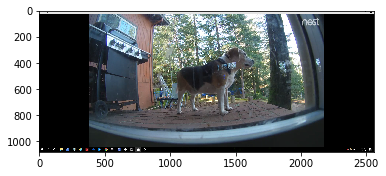

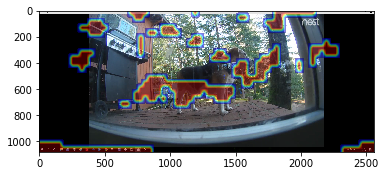

Total inference time: 0.337578058243 seconds


In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import copy
from scipy.misc import imresize
import time

MODEL_FILE = JOB_DIR + '/deploy.prototxt'                 # Do not change
PRETRAINED = JOB_DIR + '/snapshot_iter_735.caffemodel'    # Do not change                 

# Tell Caffe to use the GPU
caffe.set_mode_gpu()

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Initialize the Caffe model using the model trained in DIGITS
# This time the model input size is reshaped based on the randomly selected input image
net = caffe.Net(MODEL_FILE,PRETRAINED,caffe.TEST)
net.blobs['data'].reshape(1, 3, input_image.shape[0], input_image.shape[1])
net.reshape()
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

# This is just a colormap for displaying the results
my_cmap = copy.copy(plt.cm.get_cmap('jet')) # get a copy of the jet color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

# Feed the whole input image into the model for classification
start = time.time()
out = net.forward(data=np.asarray([transformer.preprocess('data', input_image)]))
end = time.time()

# Create an overlay visualization of the classification result
im = transformer.deprocess('data', net.blobs['data'].data[0])
classifications = out['softmax'][0]
classifications = imresize(classifications.argmax(axis=0),input_image.shape,interp='bilinear').astype('float')
classifications[classifications==0] = np.nan
plt.imshow(im)
plt.imshow(classifications,alpha=.5,cmap=my_cmap)
plt.show()

# Display total time to perform inference
print 'Total inference time: ' + str(end-start) + ' seconds'

위 코드를 반복해서 실행함에 따라 여러분은 완전 합성곱 신경망이 슬라이딩 윈도우 기법보다 더 높은 정밀도로 개를 찾아내는 것을 알게 될 것입니다. 또한, FCN의 전체 추론 시간은 0.8 초 정도로, 슬라이딩 윈도우의 2.6 초보다 우수합니다. 1 초도 안 되는 시간에 더 나은 결과를 얻었습니다! 이것은 우리가 항공기 등과 같이 실시간 애플리케이션에 감지기를 사용하기를 원할 때 큰 이점이 됩니다. 한 번의 효율적인 과정을 통해 감지와 분류를 동시에 하는 단일 모델을 얻을 수 있으니 말입니다.

하지만, 이 모델은 개의 일부분을 놓치거나 개가 아닌 일부를 잘못 감지할 수 있습니다. 어지러운 배경 속에 있는 개로 인한 잘못된 알람은 적절한 데이터 확장이나 신경망 외적인 다른 데이터 작업을 통해 완화할 수 있습니다.

이 문제를 신경망 자체적으로 더 해결할 수 있을까요?

간단한 대답은 '네'입니다.

긴 대답은 다음과 같습니다. 개를 감지하고 국지화하도록 설계된 종단 간(end-to-end) 물체 검출 신경망을 이용하면 됩니다. 우리는 [COCO](http://cocodataset.org/#home) 데이터 세트를 이용하여 훈련된  DetectNet을 사용할 것입니다. 더 나가기에 앞서 다음 코드를 실행하여 메모리를 해제하세요.

In [ ]:
try:
    del transformer
    del net
    del detections
except Exception as e:
    print e

# 세 번째 접근법: DetectNet

우리의 실습은 *이미지 분류*라는 특정한 문제를 멋지게 해결하는 AlexNet으로부터 출발했습니다. 그리고 파이썬 프로그램을 덧붙였고, 간단한 뇌수술을 진행했고, 이를 통해 우리의 이전 심층 학습에서는 불가능했던 *물체 검출*에 성공할 수 있었습니다. 

하지만 *물체 검출*에 보다 좋은 해결책이 있지는 않을까요? 다양한 크기의 사진 입력을 국지화와 검출 정보라는 출력으로 직접 매핑하는 모델을 만들 수 있지는 않을까요?

그러한 해결책이 있다는 사실은 우리가 아는 심층 학습의 지평을 넓혀주고, 심층 학습을 통해 풀 수 있는 *다른* 문제들에 대한 통찰력을 키워줍니다.

본 강좌는 심층 학습을 가능하게 만드는 세 가지 재료에 대한 논의로 출발합니다.

1) 심층 신경망
2) GPU
3) 빅 데이터

이미지 분류를 넘어서더라도 이 세 가지 재료는 여전히 사용됩니다. 하지만, 신경망과 데이터의 형식, GPU의 사용은 달라질 수 있습니다. DIGITS의 작업 흐름이 그러하므로, 데이터부터 시작하겠습니다.

## 데이터의 차이점

종단 간 지도 심층 학습(end-to-end supervised deep learning)을 만들기 위해서는 레이블 있는 데이터가 필요합니다. 지금까지 우리는 "레이블"을 각 이미지가 속하는 카테고리를 나타내는 지시자로 정의해왔습니다. 하지만 데이터에 레이블을 붙인다는 것의 핵심은 **"입출력 매핑을 큐레이트한다(curating)"**는 점입니다.

이번 사례에서 우리 입력은 임의의 크기를 가진 이미지이고 출력은 이미지 안에서의 물체의 위치입니다. 먼저 입력 이미지입니다.  

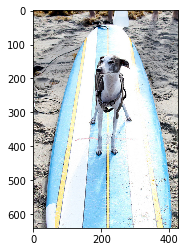

In [11]:
input_image = caffe.io.load_image('/dli/data/train/images/488156.jpg') #!ls this directory to see what other images and labels you could test
plt.imshow(input_image)
plt.show()

다음으로 상응하는 레이블입니다.

In [12]:
!cat '/dli/data/train/labels/488156.txt' #"cat" has nothing to do with the animals, this displays the text

dog 0 0 0 161.29 129.03 291.61 428.39 0 0 0 0 0 0 0
surfboard 0 0 0 31.25 36.44 410.41 640.0 0 0 0 0 0 0 0


주의:
1) 입력과 출력은 파일 숫자로 연결되어 있습니다.

2) 여러분이 보는 벡터는 입력 이미지에서 개가 위치하는 좌상단 및 아래 코너의 (x,y) 좌표로 이루어져 있습니다.

3) 만일 서프보드의 데이터가 충분하다면 개 검출기 대신에 서프보드 검출기를 만들 수도 있습니다! 여기에서는 오직 개만 찾도록 데이터 세트를 설정합니다.

이 데이터 세트를 DIGITS로 불러오세요.

 [DIGITS](/digits) 홈 화면에서 "Datasets"를 선택하고 새로운 **"Object Detection" 데이터 세트**를 추가하세요. 파라미터들이 분류의 경우와는 다르게 보일 것입니다.

"New Object Detection Dataset"이라는 패널이 열리면 아래 그림과 같은 선처리 옵션을 사용하세요. **(Watch for leading/training spaces)** 
  

* 학습 이미지 폴더: /dli/data/train/images  
* 학습 레이블 폴더: /dli/data/train/labels 
* 검증 이미지 폴더: /dli/data/val/images 
* 검증 레이블 폴더: /dli/data/val/labels/dog 
* 패드 이미지 (폭 x 높이): 640 x 640 
* 커스텀 클래스: dontcare, dog
* 그룹 이름: MS-COCO 
* 데이터 세트 이름: coco-dog

![OD data ingest](images/OD_ingest.png)

주의: 모델 학습 작업의 설정을 시작하기 위해 데이터 세트의 적재가 끝나기를 기다릴 필요는 없습니다.



## 신경망의 차이점

다양한 종류의 사물을 *학습*하기 위하여 설계된 다양한 종류의 서로 다른 인공 "두뇌"가 존재합니다. 여러분의 것과 같은 문제를 해결하는 데에 어떤 아키텍쳐가 사용되었는지를 배우는 것은 성공적인 심층 학습 기술을 습득하기 위해 핵심적인 요소입니다. 두 번째 접근법에서 몇 개의 제약 사항을 변경함으로써 신경망의 행동을 바꿀 수 있다는 것을 보았습니다. 세 번째 접근법에서는 여러분이 직접 설계자가 되지 않더라도 신경망을 사용할 수 있다는 점에 중점을 두어 연구, 전문성, 반복의 혜택을 보여드릴 것입니다. 우리가 사용할 신경망의 설계자에게 직면한 도전 과제는 **"입력과 출력의 쌍을 매핑하는 가장 효율적이고 정확한 방법은 무엇일까?"**입니다.  

신경망을 불러들이고 시각화한 후, 신경망들이 얼마나 다채로울 수 있는지 살펴보세요.

화면 좌상단의 DIGITS를 클릭해서 DIGIT의 홈 화면으로 가세요. Images -> Object Detection 을 선택해서 새로운 물체 검출 **모델**을 만드세요. 

방금 불러들인 데이터 세트인 "coco-dog"을 선택하세요.

에포크를 1로 하고 학습률을 1e-100로 하세요. 이유는 다음에 설명하겠습니다. 여러분이 신경망을 선택하던 곳으로 가서 "Custom Network"을 선택하세요. 빈 창이 열릴 것입니다.

신경망에 대한 설명은 "DetectNet deploy.prototxt"를 검색하면 찾을 수 있습니다. 여러분은 [deploy.prototxt](../../../../edit/tasks/task5/task/deploy.prototxt)에 있는 텍스트를 복사해서 해당 필드에 붙여 넣으면 됩니다. 신경망 아키텍쳐를 공유하는 것은 이처럼 쉽습니다.

다음으로는 "visualize"를 선택해서 신경망을 시각화하세요. AlexNet과 비교하여 크기와 복잡도 차이를 살펴보세요. DetectNet은 사실 우리가 전에 만들어 본 것과 같은 완전 합성곱 신경망인데, 기술된 데이터 형식의 출력을 갖도록 설정된 것입니다. DetectNet의 계층은 유명한 GoogLeNet 신경망의 계층과 같습니다.

아직 훈련을 시작하지 마세요!

## 계산식의 차이점

신경망의 깊이가 길어지고 작업의 복잡도가 늘어날수록 따라 우리가 지금껏 다루었던 신경망보다 *더 많은 학습*이 필요합니다. 이러한 작업 흐름의 능력을 보여주기 위해 우리가 사용하는 모델은 NVIDIA 테슬라 K80에서 16 시간이 걸립니다. 볼타 GPU에서는 더 적게 걸리고 CPU에서는 평생이 걸릴지도 모릅니다.

따라서 학습을 처음부터 하기보다는, 기학습된 모델을 사용하고 매우 작은 학습률을 적용하여 1 에포크 동안만 학습을 시키겠습니다. (앞에서 이미 이렇게 설정을 하였습니다.)

이미 학습된 가중치를 불러오기 위해 <code>Pretrained Model(s)</code>필드에 the file:<pre>/dli/data/digits/snapshot_iter_38600.caffemodel` 파일을 설정하세요.</pre>

[](images/loadsnapshot.PNG)

여러분의 모델이 이름을 붙이고 "학습"시켜서 이미지 분류와 물체 검출과의 차이를 살펴보세요.



여러분의 모델이 학습하는 중에 여러분은 이미지 분류 모델에서 본 것과는 다른 성능 지표를 보게 될 것입니다. 평균 정밀도의 평균값(mean Average Precision; mAP)은 검증 데이터 세트로부터 신경망이 개를 얼마나 잘 검출하면서도, 얼마나 정확하게 국지화를 하여 경계 상자(bounding box)를 찾아내는지를 나타내는 결합 지표입니다.

100 회의 학습 에포크가 지나면 모델은 낮은 학습 손실 및 검증 손실을 나타낼 뿐 아니라 높은 mAP 값을 가짐을 보실 수 있을 것입니다. 학습된 모델을 우리의 테스트 이미지로 테스트하여 개를 잘 찾아내는지 확인합시다.

**시각화 방법을 "Bounding boxes"로 설정**하고 이미지 경로 `/dli/data/BeagleImages/LouieTest1.jpg`를 붙여넣으세요. "Test One"을 클릭하세요. DetectNet이 루이를 성공적으로 검출하여 경계 상자를 그린 것을 볼 수 있을 것입니다.

다른 이미지들을 가지고 시도해보기 위해 아래 셀을 실행하세요. 주피터 노트북에서 "!"는 셀이 커맨드라인처럼 동작하도록 하는 기호입니다.

In [13]:
!ls /dli/data/BeagleImages

Louie  LouieTest1.jpg  Not Louie  louietest2.JPG


`/dli/data/BeagleImages` 폴더의 다른 이미지들을 자유로이 테스트하세요. DetectNet이 딱 붙은 경계 상자를 그려서 대부분의 개를 검출하면서도, 잘못된 알람을 발생시키는 빈도는 매우 낮다는 것을 볼 수 있을 것입니다. 또한 이 모델은 다양한 클래스의 물체를 검출할 수 있습니다!

몇 가지 꼭 기억할 사항이 있습니다. 
1. 작업에 맞는 올바른 신경망과 데이터를 선택하는 일이 여러분의 해결책을 해킹하는 것보다 훨씬 더 중요합니다.
2. 올바른 신경망(그리고 때로는 기학습된 모델)이 이미 DIGITS나 [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo)에 있을지도 모릅니다.

따라서 문제를 해결하는 데 사용할 수 있는 한 가지 프레임워크는 다음과 같습니다.

* 이미 다른 사람이 문제를 풀었는지 알아보시고, 그 모델을 사용하세요.
* 없다면 다른 사람이 여러분과 *비슷한* 문제를 풀었는지 알아보시고, 그들의 신경망과 여러분의 데이터를 사용하세요.
* 없다면, 다른 사람의 해결책으로부터 여러분의 문제를 푸는 지름길을 찾을 수 있는지 알아보시고 새 신경망을 설계하세요.
* 설계할 수 없다면, 파이썬과 같은 다른 문제 해결 기법을 사용한 해결책을 사용하세요.
* 어쨌든, 끊임없이 실험하며 여러분의 기술을 향상시킬 공부를 계속하세요!



다음 단계로 진행하기에 앞서, 여러분이 이룬 성과를 축하합시다.

여러분은 이제 다음 사항을 알고 있습니다.

* DIGITS를 이용한 다양한 형식의 신경망 학습
* 성능 향상을 위해 심층망을 학습시키는 방식에 어떤 변화를 줄 수 있는지에 대한 사항
* 새로운 문제 해결을 위해 심층 학습을 전통적인 프로그래밍과 결합하는 방법 
* 기능과 제한 사항을 바꾸기 위해 신경망의 내부 계층을 수정하는 방법
* 다른 사람들의 연구를 살펴보고 어느 부분을 가져다 사용할 수 있는지를 판별하는 능력

다음 단계에서 우리는 심층 신경망을 문제 해결을 위한 제품에 *적용*하는 방법에 대해 배웁니다. 여러분에게 필요한 정보, 배포판의 성능 지표, 최종 사용자에게 배포된 심층 학습의 계산능력과 스피드를 유지 또는 향상시키기 위한 도구 등에 대하여 자세히 다룹니다! 

<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# 해답

<a id='answer1'></a>
## 해답 1

겹치지 않는 격자를 이용한 슬라이딩 윈도우 기법은 격자가 개나 고양이의 일부만을 포함함으로써 분류에 오류를 일으킬 수 있습니다. 하지만 겹치기를 많이 하여 슬라이딩 윈도우를 적용하면 계산 시간이 급격히 늘어난다는 단점도 있습니다. 이 시간을 만회하기 위해 배치(batch) 입력을 사용하여 GPU의 병렬 처리 기능을 활용할 수 있습니다.


[여기](#question1)를 눌러 실습으로 돌아가세요.


<a id='answer-optional-exercise'></a>

### 도전 과제 실습 (선택사항)  해답

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import time

MODEL_JOB_NUM = '##FIXME##'  ## Remember to set this to be the job number for your model
DATASET_JOB_NUM = '##FIXME##'  ## Remember to set this to be the job number for your dataset

MODEL_FILE = MODEL_JOB_NUM + '/deploy.prototxt'                 # Do not change
PRETRAINED = MODEL_JOB_NUM + '/snapshot_iter_735.caffemodel'    # Do not change
MEAN_IMAGE = DATASET_JOB_NUM + '/mean.jpg'                      # Do not change

# load the mean image
mean_image = caffe.io.load_image(MEAN_IMAGE)

# Choose a random image to test against
#RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = '/dli/data/LouieReady.png' 

# Tell Caffe to use the GPU
caffe.set_mode_gpu()
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Subtract the mean image
for i in range(0,rows):
    for j in range(0,cols):
        input_image[i*256:(i+1)*256,j*256:(j+1)*256] -= mean_image
        
# Initialize an empty array for the detections
detections = np.zeros((rows,cols))
        
# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (sliding window without overlap): ' + str(end-start) + ' seconds'

# define the amount of overlap between grid cells
OVERLAP = 0.25
grid_rows = int((rows-1)/(1-OVERLAP))+1
grid_cols = int((cols-1)/(1-OVERLAP))+1

print "Image has %d*%d blocks of 256 pixels" % (rows, cols)
print "With overlap=%f grid_size=%d*%d" % (OVERLAP, grid_rows, grid_cols)

# Initialize an empty array for the detections
detections = np.zeros((grid_rows,grid_cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,grid_rows):
    for j in range(0,grid_cols):
        start_col = int(j*256*(1-OVERLAP))
        start_row = int(i*256*(1-OVERLAP))
        grid_square = input_image[start_row:start_row+256, start_col:start_col+256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print ('Total inference time (sliding window with %f%% overlap: ' % (OVERLAP*100)) + str(end-start) + ' seconds'

# now with batched inference (one column at a time)
# we are not using a caffe.Classifier here so we need to do the pre-processing
# manually. The model was trained on random crops (256*256->227*227) so we
# need to do the cropping below. Similarly, we need to convert images
# from Numpy's Height*Width*Channel (HWC) format to Channel*Height*Width (CHW) 
# Lastly, we need to swap channels from RGB to BGR
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
start = time.time()
net.blobs['data'].reshape(*[grid_cols, 3, 227, 227])

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # add to batch
        grid_square = grid_square[14:241,14:241] # 227*227 center crop        
        image = np.copy(grid_square.transpose(2,0,1)) # transpose from HWC to CHW
        image = image * 255 # rescale
        image = image[(2,1,0), :, :] # swap channels
        net.blobs['data'].data[j] = image
    # make prediction
    output = net.forward()[net.outputs[-1]]
    for j in range(0,cols):
        detections[i,j] = output[j].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (batched inference): ' + str(end-start) + ' seconds'

IOError: [Errno 2] No such file or directory: '##FIXME##/mean.jpg'



[여기](#question-optional-exercise)
를 눌러 실습으로 돌아가세요.



<a id='gu'></a>
# Fully Convolutional Network Solution

당신은 AlexNet의 **모든** 스크립트를 다음의 fully convolutional network로 변경해보실 수 있습니다. 
복사하셨다면 [여기](#fcn)를 눌러 실습으로 돌아가세요. 

```
# AlexNet
name: "AlexNet"
layer {
  name: "train-data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: true
    crop_size: 227
  }
  data_param {
    batch_size: 128
  }
  include { stage: "train" }
}
layer {
  name: "val-data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    crop_size: 227
  }
  data_param {
    batch_size: 32
  }
  include { stage: "val" }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 96
    kernel_size: 11
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "conv1"
  top: "norm1"
  lrn_param {
    local_size: 5
    alpha: 0.0001
    beta: 0.75
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "norm1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 256
    pad: 2
    kernel_size: 5
    group: 2
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "norm2"
  type: "LRN"
  bottom: "conv2"
  top: "norm2"
  lrn_param {
    local_size: 5
    alpha: 0.0001
    beta: 0.75
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "norm2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv3"
  type: "Convolution"
  bottom: "pool2"
  top: "conv3"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 384
    pad: 1
    kernel_size: 3
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "relu3"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}
layer {
  name: "conv4"
  type: "Convolution"
  bottom: "conv3"
  top: "conv4"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 384
    pad: 1
    kernel_size: 3
    group: 2
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu4"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}
layer {
  name: "conv5"
  type: "Convolution"
  bottom: "conv4"
  top: "conv5"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    group: 2
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu5"
  type: "ReLU"
  bottom: "conv5"
  top: "conv5"
}
layer {
  name: "pool5"
  type: "Pooling"
  bottom: "conv5"
  top: "pool5"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv6"
  type: "Convolution"
  bottom: "pool5"
  top: "conv6"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    pad: 0
    kernel_size: 6
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu6"
  type: "ReLU"
  bottom: "conv6"
  top: "conv6"
}
layer {
  name: "drop6"
  type: "Dropout"
  bottom: "conv6"
  top: "conv6"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv7"
  type: "Convolution"
  bottom: "conv6"
  top: "conv7"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu7"
  type: "ReLU"
  bottom: "conv7"
  top: "conv7"
}
layer {
  name: "drop7"
  type: "Dropout"
  bottom: "conv7"
  top: "conv7"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv8"
  type: "Convolution"
  bottom: "conv7"
  top: "conv8"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 2
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "conv8"
  bottom: "label"
  top: "accuracy"
  include { stage: "val" }
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "conv8"
  bottom: "label"
  top: "loss"
  exclude { stage: "deploy" }
}
layer {
  name: "softmax"
  type: "Softmax"
  bottom: "conv8"
  top: "softmax"
  include { stage: "deploy" }
}

```

[여기](#fcn)를 눌러 실습으로 돌아가세요.  